# TeamHistoryResultAnalysis
Notebook to explore ways to use data associated to the teams and its coaches

In [1]:
import os
from working_dir import set_wd
set_wd()
os.getcwd()

'/Users/tales.pimentel/ds/kaggle/football-match-prediction'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TeamHistoryAnalysis").getOrCreate()

In [3]:
import pyspark.sql.functions as f
from pyspark.sql.functions import when
import matplotlib.pyplot as plt

from src.dao import dao_raw, dao_interim, columns
from src.utils import dflib, stats, pretties, plot

In [4]:
pretties.max_data_frame_columns()

# Loading Data

In [5]:
ttrain = dao_interim.load_train_train_data(spark)
scores = dao_raw.load_parse_scores_data(spark)

drop_cols = columns.team_history_rating_cols + \
            columns.team_history_is_cup_cols + \
            columns.team_history_is_play_home_cols + \
            columns.team_history_match_date_cols + \
            columns.team_history_league_id_cols

ttrain = ttrain.drop(*drop_cols)

print(f"ttrain: {dflib.shape(ttrain)}")
print(f"scores: {dflib.shape(scores)}")

ttrain: (87470, 70)
scores: (110938, 3)


In [6]:
ttrain = scores.select(["id", "score"]).join(ttrain, on="id", how="inner")
print(f"train: {dflib.shape(ttrain)}")

train: (87470, 71)


In [7]:
basic_cols = ['id', 'score', 'target', 'home_team_name', 'away_team_name', 
              'match_date', 'league_name']

# Coach Analysis

### How many matches with invalid coach_id?

In [8]:
null_home_coach_matches = ttrain.filter(f.col("home_team_coach_id").isNull()).count()
null_away_coach_matches = ttrain.filter(f.col("away_team_coach_id").isNull()).count()

print("HOME", "total:", null_home_coach_matches, "freq:", round(null_home_coach_matches / ttrain.count(), 4))
print("AWAY", "total:", null_away_coach_matches, "freq:", round(null_away_coach_matches / ttrain.count(), 4))

HOME total: 16285 freq: 0.1862
AWAY total: 16351 freq: 0.1869


### How many matches the coach had played? 

HOME
+------------------+---------+
|home_team_coach_id|n_matches|
+------------------+---------+
|              null|    16285|
|        37252510.0|     4455|
|          524307.0|       40|
|         2511092.0|       40|
|            7862.0|       39|
+------------------+---------+

+---------+--------+--------+
|n_matches|Absolute|Relative|
+---------+--------+--------+
|        1|     933|   0.119|
|        2|     713|  0.0909|
|        3|     639|  0.0815|
|        4|     534|  0.0681|
|        5|     507|  0.0647|
+---------+--------+--------+



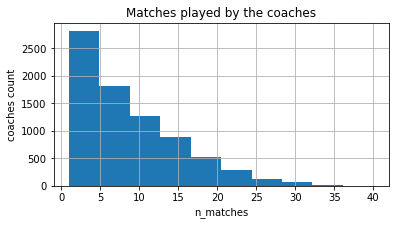

AWAY
+------------------+---------+
|away_team_coach_id|n_matches|
+------------------+---------+
|              null|    16351|
|        37252510.0|     4512|
|          455361.0|       39|
|          466541.0|       38|
|          524307.0|       38|
+------------------+---------+

+---------+--------+--------+
|n_matches|Absolute|Relative|
+---------+--------+--------+
|        1|     958|  0.1204|
|        2|     785|  0.0986|
|        3|     633|  0.0795|
|        4|     574|  0.0721|
|        6|     479|  0.0602|
+---------+--------+--------+



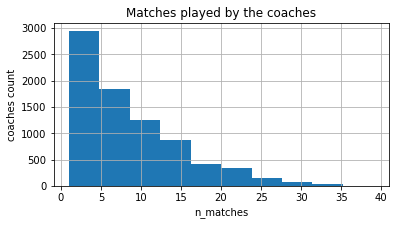

In [9]:
home_coach_n_matches = ttrain.groupBy("home_team_coach_id").agg(f.count("*").alias("n_matches")).sort("n_matches", ascending=False)
away_coach_n_matches = ttrain.groupBy("away_team_coach_id").agg(f.count("*").alias("n_matches")).sort("n_matches", ascending=False)

print("HOME")
home_coach_n_matches.limit(5).show()
stats.freq(home_coach_n_matches, "n_matches", 4).sort("Absolute", ascending=False).limit(5).show()
plot.hist(home_coach_n_matches.filter(f.col("n_matches") < 1000), "n_matches", ylabel="coaches count", bins=10, title="Matches played by the coaches")
pretties.hr()
print("AWAY")
away_coach_n_matches.limit(5).show()
stats.freq(away_coach_n_matches, "n_matches", 4).sort("Absolute", ascending=False).limit(5).show()
plot.hist(away_coach_n_matches.filter(f.col("n_matches") < 1000), "n_matches", ylabel="coaches count", bins=10, title="Matches played by the coaches")

### How many coaches the club had? 

In [10]:
home_clubs_per_coach = ttrain.groupBy("home_team_coach_id").agg(f.count_distinct("home_team_name").alias("n_clubs")).sort("n_clubs", ascending=False)
away_clubs_per_coach = ttrain.groupBy("away_team_coach_id").agg(f.count_distinct("away_team_name").alias("n_clubs")).sort("n_clubs", ascending=False)

print("HOME")
stats.freq(home_clubs_per_coach, "n_clubs", 4).sort("Absolute", ascending=False).show()
home_clubs_per_coach.limit(4).show()
pretties.hr()
print("AWAY")
stats.freq(away_clubs_per_coach, "n_clubs", 4).sort("Absolute", ascending=False).show()
away_clubs_per_coach.limit(4).show()

HOME
+-------+--------+--------+
|n_clubs|Absolute|Relative|
+-------+--------+--------+
|      1|    6860|  0.8748|
|      2|     905|  0.1154|
|      3|      71|  0.0091|
|      4|       4|  5.0E-4|
|   4053|       1|  1.0E-4|
|   1588|       1|  1.0E-4|
+-------+--------+--------+

+------------------+-------+
|home_team_coach_id|n_clubs|
+------------------+-------+
|              null|   4053|
|        37252510.0|   1588|
|          456680.0|      4|
|        37341751.0|      4|
+------------------+-------+



AWAY
+-------+--------+--------+
|n_clubs|Absolute|Relative|
+-------+--------+--------+
|      1|    6955|  0.8739|
|      2|     928|  0.1166|
|      3|      68|  0.0085|
|      4|       6|  8.0E-4|
|   4126|       1|  1.0E-4|
|   1628|       1|  1.0E-4|
+-------+--------+--------+

+------------------+-------+
|away_team_coach_id|n_clubs|
+------------------+-------+
|              null|   4126|
|        37252510.0|   1628|
|          459324.0|      4|
|          524244.0|      4|
+------------------+-------+



### How many clubs the coach had?

In [11]:
home_coaches_per_club = ttrain.groupBy("home_team_name").agg(f.count_distinct("home_team_coach_id").alias("n_coaches")).sort("n_coaches", ascending=False)
away_coaches_per_club = ttrain.groupBy("away_team_name").agg(f.count_distinct("away_team_coach_id").alias("n_coaches")).sort("n_coaches", ascending=False)

print("HOME")
stats.freq(home_coaches_per_club, "n_coaches", 4).sort("Absolute", ascending=False).show()
home_coaches_per_club.limit(6).show()
pretties.hr()
print("AWAY")
stats.freq(home_coaches_per_club, "n_coaches", 4).sort("Absolute", ascending=False).show()
home_coaches_per_club.limit(6).show()

HOME
+---------+--------+--------+
|n_coaches|Absolute|Relative|
+---------+--------+--------+
|        1|    5141|  0.5452|
|        0|    2127|  0.2256|
|        2|    1435|  0.1522|
|        3|     515|  0.0546|
|        4|     147|  0.0156|
|        5|      42|  0.0045|
|        6|      21|  0.0022|
|        7|       1|  1.0E-4|
+---------+--------+--------+

+--------------+---------+
|home_team_name|n_coaches|
+--------------+---------+
| Independiente|        7|
|   Denizlispor|        6|
|      Arambagh|        6|
|       Ismaily|        6|
| Balıkesirspor|        6|
|         APOEL|        6|
+--------------+---------+



AWAY
+---------+--------+--------+
|n_coaches|Absolute|Relative|
+---------+--------+--------+
|        1|    5141|  0.5452|
|        0|    2127|  0.2256|
|        2|    1435|  0.1522|
|        3|     515|  0.0546|
|        4|     147|  0.0156|
|        5|      42|  0.0045|
|        6|      21|  0.0022|
|        7|       1|  1.0E-4|
+---------+--------+--------+

+--------------+---------+
|home_team_name|n_coaches|
+--------------+---------+
| Independiente|        7|
|   Denizlispor|        6|
|      Arambagh|        6|
|       Ismaily|        6|
| Balıkesirspor|        6|
|         APOEL|        6|
+--------------+---------+



#### Notes
Unfortunately, due to the huge number of invalid coach_id, the decision taken is to switch to team analysis instead.

# Team Analysis

### How frequent were the team victories?

In [12]:
def team_history_result(df, which, team_goals_cols, team_opponent_goals_cols):

    for i in range(1, 11, 1):
        team_goals_colname = team_goals_cols[i-1]
        team_opponent_goals_colname = team_opponent_goals_cols[i-1]

        team_result_history = f"{which}_result_history_{i}"
        
        df = df.withColumn(
             team_result_history, 
             f.col(team_goals_colname) - f.col(team_opponent_goals_colname)).withColumn(
                 team_result_history, f.when(f.col(team_result_history) > 0, 1).otherwise(f.when(f.col(team_result_history) < 0, -1).otherwise(f.lit(0))))
    return df

In [13]:
ttrain = team_history_result(ttrain, which="home", 
                             team_goals_cols=columns.home_team_history_goal_cols, 
                             team_opponent_goals_cols=columns.home_team_history_opponent_goal_cols)

ttrain = team_history_result(ttrain, which="away", 
                             team_goals_cols=columns.away_team_history_goal_cols, 
                             team_opponent_goals_cols=columns.away_team_history_opponent_goal_cols)

In [14]:
home_result_history_colnames = [f"home_result_history_{i}" for i in range(1,11,1)]
away_result_history_colnames = [f"away_result_history_{i}" for i in range(1,11,1)]

result_history_colnames = home_result_history_colnames + away_result_history_colnames

In [15]:
home_result_history_mean = stats.row_mean(ttrain, home_result_history_colnames, "home_result_history_mean", index_colname="id")
away_result_history_mean = stats.row_mean(ttrain, away_result_history_colnames, "away_result_history_mean", index_colname="id")

In [16]:
ttrain = ttrain.join(home_result_history_mean, on="id", how="left").join(away_result_history_mean, on="id", how="left")

### Checking plots

In [17]:
print("HOME")
ttrain.groupBy("target").agg(f.percentile_approx("home_result_history_mean", 0.5).alias("median")).show()
print("AWAY")
ttrain.groupBy("target").agg(f.percentile_approx("away_result_history_mean", 0.5).alias("median")).show()

HOME
+------+------+
|target|median|
+------+------+
|  away|  -0.1|
|  home|   0.1|
|  draw|   0.0|
+------+------+

AWAY
+------+------+
|target|median|
+------+------+
|  away|   0.1|
|  home|   0.0|
|  draw|   0.0|
+------+------+



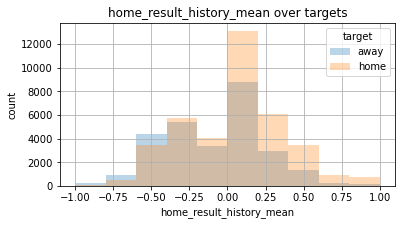

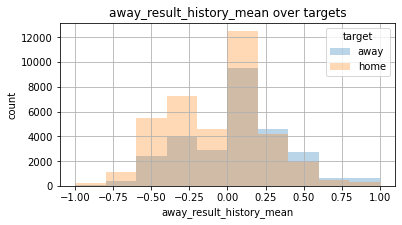

In [18]:
plot.hist_overlay(ttrain, "target", "home_result_history_mean", title="home_result_history_mean over targets", alpha=0.3)
plot.hist_overlay(ttrain, "target", "away_result_history_mean", title="away_result_history_mean over targets", alpha=0.3)

#### Notes
It seems that when the AWAY team has a bad result_history_mean (less than 0) the HOME team wins almost double the times.

# Conclusion

Maybe this feature would help a little bit. <br>